In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
#| default_exp util.set_seed
from nbdev.showdoc import show_doc

In ["Swin Transformer: Hierarchical Vision Transformer using Shifted Windows"] (https://arxiv.org/pdf/2103.14030.pdf), the relative positional encoding is used to capture translation invariance. In this notebook, we will implement it from scratch.


In [2]:
import torch
import torch.nn as nn


class ActivationFunction(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {"name": self.name}
    

In [3]:
class Sigmoid(ActivationFunction):
    def forward(self, x):
        return 1 / (1 + torch.exp(-x))


class Tanh(ActivationFunction):
    def forward(self, x):
        x_exp, neg_x_exp = torch.exp(x), torch.exp(-x)
        return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)

In [4]:
class ReLU(ActivationFunction):
    def forward(self, x):
        return x * (x > 0).float()


class LeakyReLU(ActivationFunction):
    def __init__(self, alpha=0.1):
        super().__init__()
        self.config["alpha"] = alpha

    def forward(self, x):
        return torch.where(x > 0, x, self.config["alpha"] * x)


class ELU(ActivationFunction):
    def forward(self, x):
        return torch.where(x > 0, x, torch.exp(x) - 1)


class Swish(ActivationFunction):
    def forward(self, x):
        return x * torch.sigmoid(x)

In [8]:
#| hide
import nbdev; nbdev.nbdev_export()

In [5]:
act_fn_by_name = {"sigmoid": Sigmoid, "tanh": Tanh, "relu": ReLU, "leakyrelu": LeakyReLU, "elu": ELU, "swish": Swish}

In [6]:
def get_grads(act_fn, x):
    """Computes the gradients of an activation function at specified positions.

    Args:
        act_fn: An object of the class "ActivationFunction" with an implemented forward pass.
        x: 1D input tensor.

    Returns:
        A tensor with the same size of x containing the gradients of act_fn at x.
    """
    x = x.clone().requires_grad_()  # Mark the input as tensor for which we want to store gradients
    out = act_fn(x)
    out.sum().backward()  # Summing results in an equal gradient flow to each element in x
    return x.grad  # Accessing the gradients of x by "x.grad"

In [7]:
#| export

def vis_act_fn(act_fn, ax, x):
    # Run activation function
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)
    # Push x, y and gradients back to cpu for plotting
    x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
    # Plotting
    ax.plot(x, y, linewidth=2, label="ActFn")
    ax.plot(x, y_grads, linewidth=2, label="Gradient")
    ax.set_title(act_fn.name)
    ax.legend()
    ax.set_ylim(-1.5, x.max())

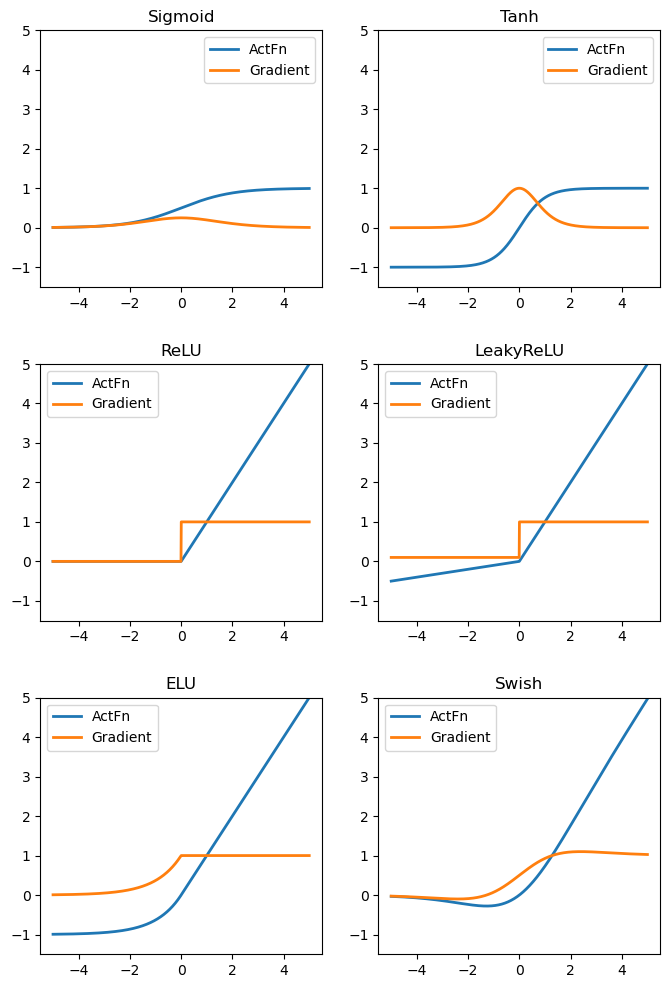

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

# Add activation functions if wanted
act_fns = [act_fn() for act_fn in act_fn_by_name.values()]
x = torch.linspace(-5, 5, 1000)  # Range on which we want to visualize the activation functions
# Plotting
cols = 2
rows = math.ceil(len(act_fns) / float(cols))
fig, ax = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
for i, act_fn in enumerate(act_fns):
    vis_act_fn(act_fn, ax[divmod(i, cols)], x)
fig.subplots_adjust(hspace=0.3)
plt.show()